In [191]:
import netCDF4 as nc
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import timeit
import geopandas 
import dask.dataframe as dd

In [203]:
#read NASA datafile
ds=xr.open_mfdataset('/Users/alexandrapopova/Desktop/MSc Energy Systems/Dissertation/data/MERRA_Jan_Data/*.nc4', parallel=True)

In [204]:
#select only speed and European coordinates
ds=ds['SPEED']
ds=ds.sel(lon=slice(-25,65)).sel(lat=slice(35,72))

In [265]:
ds.head()

<xarray.DataArray 'SPEED' (time: 5, lat: 5, lon: 5)>
dask.array<getitem, shape=(5, 5, 5), dtype=float32, chunksize=(5, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -25.0 -24.38 -23.75 -23.12 -22.5
  * lat      (lat) float64 35.0 35.5 36.0 36.5 37.0
  * time     (time) datetime64[ns] 2020-01-01T00:30:00 ... 2020-01-01T04:30:00
Attributes:
    long_name:       surface_wind_speed
    units:           m s-1
    fmissing_value:  1000000000000000.0
    standard_name:   surface_wind_speed
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [270]:
#convert to dataframe
source_df= ds.to_dataframe()

In [271]:
source_df.head()

SPEED
time                lat  lon               
2020-01-01 00:30:00 35.0 -25.000  11.829979
                         -24.375  10.767479
                         -23.750   9.763573
                         -23.125   9.427635
                         -22.500   9.427635

In [272]:
#reset names and indices 
source_df=source_df.rename(columns={"SPEED": "Wind_Speed"})
source_df=source_df.reset_index()

In [273]:
source_df.head()

,time,lat,lon,Wind_Speed
0,2020-01-01 00:30:00,35.0,-25.000,11.829979
1,2020-01-01 00:30:00,35.0,-24.375,10.767479
2,2020-01-01 00:30:00,35.0,-23.750,9.763573
3,2020-01-01 00:30:00,35.0,-23.125,9.427635
4,2020-01-01 00:30:00,35.0,-22.500,9.427635


In [285]:
#split datetime into date and time to aggregate next
source_df['newdate']=source_df['time'].dt.date
source_df['newtime']=source_df['time'].dt.time

UsageError: Line magic function `%%timeit` not found.


In [286]:
aggr_df=source_df.groupby(['lat','lon','newtime'] ).agg({'Wind_Speed': ['mean', 'max', np.std, 'count']})

In [287]:
aggr_df.head()

Wind_Speed                           
                          mean        max       std count
lat  lon   newtime                                       
35.0 -25.0 00:30:00   6.968696  14.929451  3.093047    31
           01:30:00   7.030191  14.783817  3.159208    31
           02:30:00   7.110409  14.560913  3.201967    31
           03:30:00   7.164998  13.925628  3.201419    31
           04:30:00   7.137935  13.128662  3.219707    31

In [288]:
aggr_df=aggr_df.reset_index()

In [289]:
z=1.645 # 90% confidence interval

In [290]:
aggr_df['Wind_Speed_Min']=aggr_df['Wind_Speed']['mean']-z*aggr_df['Wind_Speed']['std']/np.sqrt(aggr_df['Wind_Speed']['count'])

In [291]:
aggr_df['Wind_Speed_Max']=aggr_df['Wind_Speed']['mean']+z*aggr_df['Wind_Speed']['std']/np.sqrt(aggr_df['Wind_Speed']['count'])

In [292]:
aggr_df=aggr_df.drop(columns='Wind_Speed')

/Users/alexandrapopova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [332]:
aggr_df=aggr_df.rename(columns={"newtime": "time"})


SyntaxError: invalid syntax (<ipython-input-332-48cfd943a3ae>, line 2)

In [333]:
aggr_df.columns = aggr_df.columns.droplevel(-1)

In [294]:
def Vestas_Power(x):
    if x < 4:
        return 0
    else:
        if (x>=4) and (x<13):
            return (260.04*x-312.8)
        else: 
            if (x>=13) and (x<=25):
                return 2000
            else:
                return 0

In [295]:
def Enercon_Power(x):
    if x < 3:
        return 0
    else:
        if (x>=3) and (x<17):
            return (676.04*x-1502.5)
        else: 
            if (x>=17) and (x<=34):
                return 7580
            else:
                return 0

In [296]:
aggr_df['Vestas_Power_Min']=aggr_df['Wind_Speed_Min'].apply(Vestas_Power)
aggr_df['Vestas_Power_Max']=aggr_df['Wind_Speed_Max'].apply(Vestas_Power)

In [298]:
aggr_df['Enercon_Power_Min']=aggr_df['Wind_Speed_Min'].apply(Enercon_Power)
aggr_df['Enercon_Power_Max']=aggr_df['Wind_Speed_Max'].apply(Enercon_Power)

In [299]:
aggr_df['Vestas_Energy_Min_MWh']=aggr_df['Vestas_Power_Min']/1000
aggr_df['Vestas_Energy_Max_MWh']=aggr_df['Vestas_Power_Max']/1000
aggr_df['Enercon_Energy_Min_MWh']=aggr_df['Enercon_Power_Min']/1000
aggr_df['Enercon_Energy_Max_MWh']=aggr_df['Enercon_Power_Max']/1000

In [300]:
aggr_df['hour']=pd.Series(np.tile([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],int(len(df)/24)))

In [311]:
aggr_df['lon']=aggr_df['lon'].round(3)

In [314]:
aggr_df.loc[983]

lat                                35
lon                                -0
Vestas_Energy_Min_MWh        0.943244
Vestas_Energy_Max_MWh         1.32753
Enercon_Energy_Min_MWh        1.76291
Enercon_Energy_Max_MWh        2.76197
hour                               24
coords                      35.0,-0.0
Name: 983, dtype: object

In [315]:
aggr_df=aggr_df.drop(columns=['time','Wind_Speed_Min','Wind_Speed_Max', 'Vestas_Power_Min', 'Vestas_Power_Max','Enercon_Power_Min','Enercon_Power_Max'])
#day_sum_df=day_sum_df.groupby(['lat','lon']).sum()

KeyError: 'time'

In [313]:
aggr_df['coords']=aggr_df['lat'].astype(str)+ "," + aggr_df['lon'].astype(str)

In [318]:
coord_df=pd.read_csv('/Users/alexandrapopova/Desktop/MSc Energy Systems/Dissertation/data/coords_on_land.csv')
coord_df['coords']=coord_df['lat'].astype(str)+ "," + coord_df['lon'].astype(str)
aggr_df['on_land'] = aggr_df.coords.map(coord_df.set_index('coords')['on_land'].to_dict())

In [320]:
aggr_df.head()

,lat,lon,Vestas_Energy_Min_MWh,Vestas_Energy_Max_MWh,Enercon_Energy_Min_MWh,Enercon_Energy_Max_MWh,hour,coords,on_land
,,,,,,,,,
0,35.0,-25.0,1.261704,1.736975,2.590823,3.826411,1,"35.0,-25.0",0
1,35.0,-25.0,1.272612,1.758050,2.619181,3.881199,2,"35.0,-25.0",0
2,35.0,-25.0,1.290187,1.782195,2.664871,3.943970,3,"35.0,-25.0",0
3,35.0,-25.0,1.304424,1.796348,2.701885,3.980766,4,"35.0,-25.0",0
4,35.0,-25.0,1.295982,1.790716,2.679937,3.966123,5,"35.0,-25.0",0


In [110]:
aggr_df.to_csv('day_sum_df.csv')

In [322]:
#model variable coefficients
v_cost=50
e_cost=100
v_ener_mean=aggr_df['Vestas_Energy_Min_MWh'].to_numpy()
v_ener_mean=v_ener_mean.reshape(int(len(aggr_df)/24),24)
v_ener_max=aggr_df['Vestas_Energy_Max_MWh'].to_numpy()
v_ener_max=v_ener_max.reshape(int(len(aggr_df)/24),24)
e_ener_mean=aggr_df['Enercon_Energy_Min_MWh'].to_numpy()
e_ener_mean=e_ener_mean.reshape(int(len(aggr_df)/24),24)
e_ener_max=aggr_df['Enercon_Energy_Max_MWh'].to_numpy()
e_ener_max=e_ener_max.reshape(int(len(aggr_df)/24),24)
on_land=aggr_df['on_land'].to_numpy()
on_land=on_land.reshape(int(len(aggr_df)/24),24)
on_land=on_land[:,1]

In [323]:
energy_need=np.array([100,100,100,150,200,300,400,500,500,500,400,600,600,500,500,500,500,600,700,700,400,200,150,100])

In [327]:
energy_need_max=energy_need*10

In [328]:
#cost minimisation model
import gurobipy as gp
from gurobipy import GRB
I=range(int(day_sum_df.shape[0]/24))
J=range(2)
H=range(24)
m=gp.Model()
x = [[m.addVar(vtype=GRB.BINARY) for j in J] for i in I] #binary variables
for i in I:
    m.addConstr((x[i][0]+x[i][1]) <= 1) #no more than 1 turbine per mode
for h in H:
    m.addConstr(gp.quicksum(v_ener_mean[i][h]*x[i][0]*on_land[i]+e_ener_mean[i][h]*x[i][1]*on_land[i] for i in I) >= energy_need[h]) #lower constraint on energy produced
for h in H:
    m.addConstr(gp.quicksum(v_ener_max[i][h]*x[i][0]*on_land[i]+e_ener_max[i][h]*x[i][1]*on_land[i] for i in I) <= energy_need_max[h]) #upped constraint on energy produced
        
m.setObjective(gp.quicksum(v_cost * x[i][0]+e_cost*x[i][1] for i in I), GRB.MINIMIZE)
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10923 rows, 21750 columns and 560543 nonzeros
Model fingerprint: 0xe8e22702
Variable types: 0 continuous, 21750 integer (21750 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+01]
  Objective range  [5e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+03]
Found heuristic solution: objective 26350.000000
Presolve removed 5440 rows and 10476 columns
Presolve time: 1.40s
Presolved: 5483 rows, 11274 columns, 185218 nonzeros
Variable types: 0 continuous, 11274 integer (11274 binary)

Root relaxation: objective 1.210943e+04, 35 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12109.4272    0    1 26350.0000 12109.4272  54.0%     -    1s
H    0     0                

In [334]:
#append model results (location of turbines) to coordinates

solution_df=aggr_df.loc[aggr_df['hour'] == 1].reset_index()
vars=m.getVars()
Vestas_Location=np.array([])
Enercon_Location=np.array([])
for v in range(m.NumVars):
    if v % 2 == 0:
        Vestas_Location=np.append(Vestas_Location,vars[v].x)
    else:
        Enercon_Location=np.append(Enercon_Location,vars[v].x)
solution_df['Vestas_Location']=pd.Series(Vestas_Location)
solution_df['Enercon_Location']=pd.Series(Enercon_Location)

In [133]:
day_sum_df_sol.to_csv('turbine_locations.csv')

In [335]:
#convert dataframe to geopandas and write to file
#df_sol=df_sol.drop(columns=['index','Vestas_Energy_Mean_MWh','Vestas_Energy_Max_MWh','Enercon_Energy_Mean_MWh','Enercon_Energy_Max_MWh','on_land'])
gdf = geopandas.GeoDataFrame(
    solution_df, geometry=geopandas.points_from_xy((solution_df['lon']), (solution_df['lat'])))

gdf.to_file("turbine_map3.geojson", driver="GeoJSON")  

In [561]:
day_sum_df=df.drop(columns=['lev','time','E_Wind_Speed', 'N_Wind_Speed','Wind_Speed', 'Vestas_Power', 'Enercon_Power'])
day_sum_df=day_sum_df.groupby(['lat','lon']).mean()
day_avg_df=day_avg_df.reset_index()
day_avg_df=day_avg_df.apply(pd.to_numeric)

In [562]:
#transpose wind speed array into a matrix
unique_lon, counts_lon = np.unique(day_avg_df['lon'], return_counts=True)
unique_lat, counts_lat = np.unique(day_avg_df['lat'], return_counts=True)
wind_speed=day_avg_df['Wind_Speed'].to_numpy()
wind_speed=wind_speed.reshape(int(counts_lon[0]),int(counts_lat[0]))

/Users/alexandrapopova/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:385: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


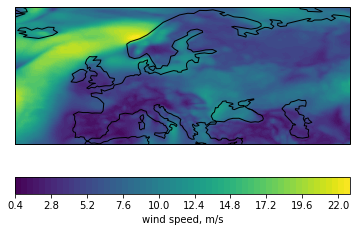

In [563]:
#create countour map for the average speed
lats = np.unique(day_avg_df['lat'])
lons = np.unique(day_avg_df['lon'])

ax = plt.axes(projection=ccrs.PlateCarree())

p=plt.contourf(lons, lats, wind_speed, 60,
             transform=ccrs.PlateCarree())


ax.coastlines()
cbar=plt.colorbar(p, label="wind speed, m/s",orientation="horizontal")

plt.show()

In [460]:
#convert the countour map into geojson

import geojsoncontour
contourf = ax.contourf(lons, lats, wind_speed, 10, cmap=plt.cm.jet)
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=3,
    stroke_width=2,
    fill_opacity=0.5
)

file = open("Wind_Speed.geojson", "w")
file.write(geojson)
file.close()